# Use CTSRD traffic sign dataset to train a ResNet101 classification model  
Reference:  
1.[Chinese Traffic Sign Database](http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import random
import pandas as pd
import cv2
import os
import time

print(tf.__version__)

1.15.0


In [2]:
df = pd.read_csv("./dataset/CTSRD_labels.csv", encoding='gbk')
df = df.sample(frac=1).reset_index(drop=True) # shuffle the datadrame
df

,filename,class_id,name
0,016_1_0001_1_j.png,16,禁止机动车
1,054_1_0068.png,54,禁止车辆临时或长时停放
2,003_0123.png,3,限速40km/h
3,037_1_0005_1_j.png,37,注意学校
4,028_1_0048.png,28,机动车道
...,...,...,...
5993,055_0068.png,55,禁止驶入
5994,024_1_0018.png,24,右转
5995,028_0210.png,28,机动车道
5996,054_0055_j.png,54,禁止车辆临时或长时停放


(array([132.,  52., 104., 318., 156., 244., 108., 202.,  22.,   2., 130.,
        246., 118., 128., 140.,  58., 218., 192.,   8.,   4.,  20.,  24.,
         26.,  16., 112.,   4., 260.,  52., 514.,  70., 184.,  60.,  16.,
          4.,  30., 202.,  44.,  84.,  70.,  64.,  40.,  26.,  50., 188.,
         54.,  26.,  32.,  22.,  16.,  84.,  76.,  12.,  50.,   4., 500.,
        220., 150.,  10.]),
 array([ 0.        ,  0.98275862,  1.96551724,  2.94827586,  3.93103448,
         4.9137931 ,  5.89655172,  6.87931034,  7.86206897,  8.84482759,
         9.82758621, 10.81034483, 11.79310345, 12.77586207, 13.75862069,
        14.74137931, 15.72413793, 16.70689655, 17.68965517, 18.67241379,
        19.65517241, 20.63793103, 21.62068966, 22.60344828, 23.5862069 ,
        24.56896552, 25.55172414, 26.53448276, 27.51724138, 28.5       ,
        29.48275862, 30.46551724, 31.44827586, 32.43103448, 33.4137931 ,
        34.39655172, 35.37931034, 36.36206897, 37.34482759, 38.32758621,
        39.3103448

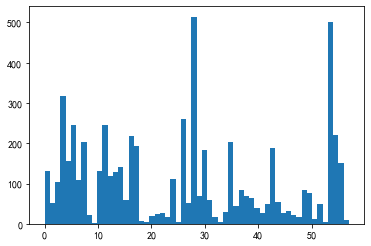

In [3]:
plt.hist(df['class_id'], 58)

In [4]:
batch_size = 32
sizeX, sizeY = 112, 112
apply_DataAugumentation = True

if apply_DataAugumentation:
    datagen=ImageDataGenerator(rescale=1./255, 
                               validation_split=0.3,
                               rotation_range=5,
                               width_shift_range=0.05,
                               height_shift_range=0.05,
                               zoom_range=[0.95, 1.05],
                               fill_mode='reflect'
                              )
else:
    datagen=ImageDataGenerator(rescale=1./255, validation_split=0.3)
                          
                          
trainset = datagen.flow_from_dataframe(dataframe=df, directory='./dataset/CTSRD_resized',
                                       x_col='filename', y_col='name', class_mode='categorical', target_size=(sizeX,sizeY),
                                       batch_size=batch_size, shuffle=True, seed=42, subset='training')
testset = datagen.flow_from_dataframe(dataframe=df, directory='./dataset/CTSRD_resized',
                                      x_col='filename', y_col='name', class_mode='categorical', target_size=(sizeX,sizeY),
                                      batch_size=batch_size, shuffle=True, seed=42, subset='validation')

Found 4199 validated image filenames belonging to 58 classes.
Found 1799 validated image filenames belonging to 58 classes.


In [5]:
names = trainset.class_indices

def getname(index):
    return list(names)[index]

names

{'停车检查': 0,
 '停车让行': 1,
 '减速让行': 2,
 '右侧行驶': 3,
 '右转': 4,
 '左侧行驶': 5,
 '左转': 6,
 '左转和右转': 7,
 '机动车道': 8,
 '注意上坡': 9,
 '注意下坡': 10,
 '注意事故易发路段': 11,
 '注意人行横道': 12,
 '注意信号灯': 13,
 '注意危险': 14,
 '注意反向弯路': 15,
 '注意向右T型交叉': 16,
 '注意向右急转弯': 17,
 '注意向左T型交叉': 18,
 '注意向左急转弯': 19,
 '注意学校': 20,
 '注意左右绕行': 21,
 '注意慢行': 22,
 '注意施工': 23,
 '注意无人看守铁道路口': 24,
 '注意有人看守铁道路口': 25,
 '注意村镇': 26,
 '注意连续弯道': 27,
 '注意非机动车': 28,
 '环岛': 29,
 '直行': 30,
 '直行和右转': 31,
 '禁止右转': 32,
 '禁止左转': 33,
 '禁止左转和右转': 34,
 '禁止机动车': 35,
 '禁止直行': 36,
 '禁止直行和右转': 37,
 '禁止直行和左转': 38,
 '禁止调头': 39,
 '禁止超车': 40,
 '禁止车辆临时或长时停放': 41,
 '禁止通行': 42,
 '禁止驶入': 43,
 '禁止鸣笛': 44,
 '解除40km/h限速': 45,
 '解除50km/h限速': 46,
 '调头': 47,
 '限速15km/h': 48,
 '限速30km/h': 49,
 '限速40km/h': 50,
 '限速50km/h': 51,
 '限速5km/h': 52,
 '限速60km/h': 53,
 '限速70km/h': 54,
 '限速80km/h': 55,
 '非机动车道': 56,
 '鸣笛': 57}

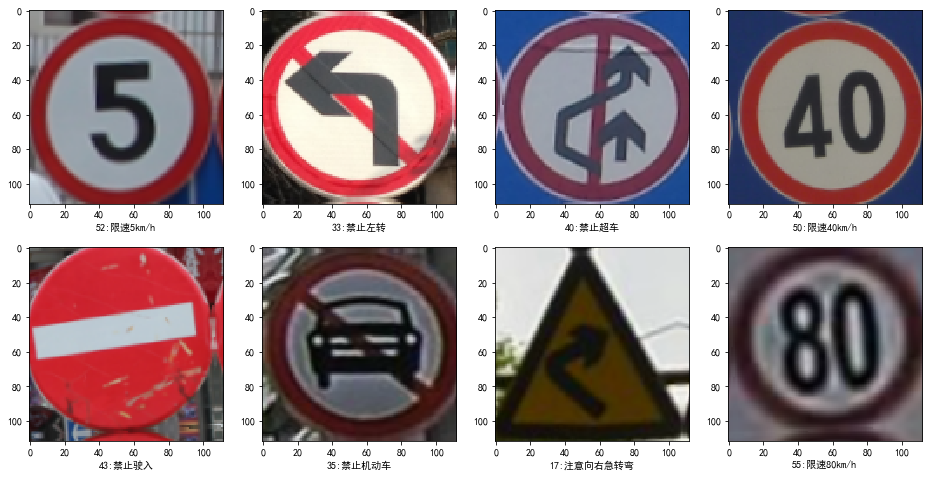

In [6]:
plt.figure(figsize=(16,8))
n = 123 # index of the batch you want to observe
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(trainset[n][0][i])
    index = np.argmax(trainset[n][1][i])
    plt.xlabel(str(index) + ':' + getname(index))

In [7]:
input_shape = (sizeX, sizeY, 3)

from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.regularizers import l2

base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

print(base_model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 118, 118, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 56, 56, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 56, 56, 64)   256         conv1_conv[0][0]                 
_________

In [8]:
x = base_model.output
x = keras.layers.AveragePooling2D(pool_size=(4, 4))(x)
x = keras.layers.Dropout(.4)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(58, kernel_initializer='glorot_uniform', kernel_regularizer=l2(.0005), activation='softmax')(x)

model_finetune = Model(inputs=base_model.input, outputs=x)

model_finetune.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 118, 118, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 56, 56, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 56, 56, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
def schedule(epoch):
    if epoch <= 3:
        return .01
    elif epoch <= 7:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

sgd = keras.optimizers.SGD(lr=.01, momentum=.9)

model_finetune.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=["accuracy"])

In [10]:
STEP_SIZE_TRAIN=trainset.n//trainset.batch_size
STEP_SIZE_VALID=testset.n//testset.batch_size
print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

model_finetune.fit_generator(generator=trainset,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=testset,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    callbacks=[lr_scheduler]
)

131 56
Epoch 1/10
131/131 [==============================] - 79s 602ms/step - loss: 0.8117 - acc: 0.8287 - val_loss: 5.7275 - val_acc: 0.0028
Epoch 2/10
131/131 [==============================] - 51s 386ms/step - loss: 0.1442 - acc: 0.9772 - val_loss: 5.1188 - val_acc: 0.0028
Epoch 3/10
131/131 [==============================] - 50s 383ms/step - loss: 0.0939 - acc: 0.9916 - val_loss: 5.7917 - val_acc: 0.0033
Epoch 4/10
131/131 [==============================] - 50s 383ms/step - loss: 0.0639 - acc: 0.9990 - val_loss: 5.6289 - val_acc: 0.0151
Epoch 5/10
131/131 [==============================] - 54s 410ms/step - loss: 0.0604 - acc: 1.0000 - val_loss: 4.0455 - val_acc: 0.2288
Epoch 6/10
131/131 [==============================] - 51s 388ms/step - loss: 0.0600 - acc: 0.9998 - val_loss: 0.8710 - val_acc: 0.7980
Epoch 7/10
131/131 [==============================] - 50s 385ms/step - loss: 0.0592 - acc: 0.9998 - val_loss: 0.1125 - val_acc: 0.9849
Epoch 8/10
131/131 [============================

In [11]:
model_finetune.evaluate_generator(testset,verbose=1)

57/57 [==============================] - 9s 165ms/step - loss: 0.0604 - acc: 0.9989


[0.060391432622022796, 0.99888825]

In [16]:
modelname = 'CTSRD_ResNet101_' + time.strftime("%Y%m%d_%H%M%S", time.localtime())
model_finetune.save('./trainedModels/' + modelname + '.h5')

## Prediction (Separate)

In [12]:
modelname = 'CTSRD_ResNet101_20200422'
model = keras.models.load_model('./trainedModels/' + modelname + '.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


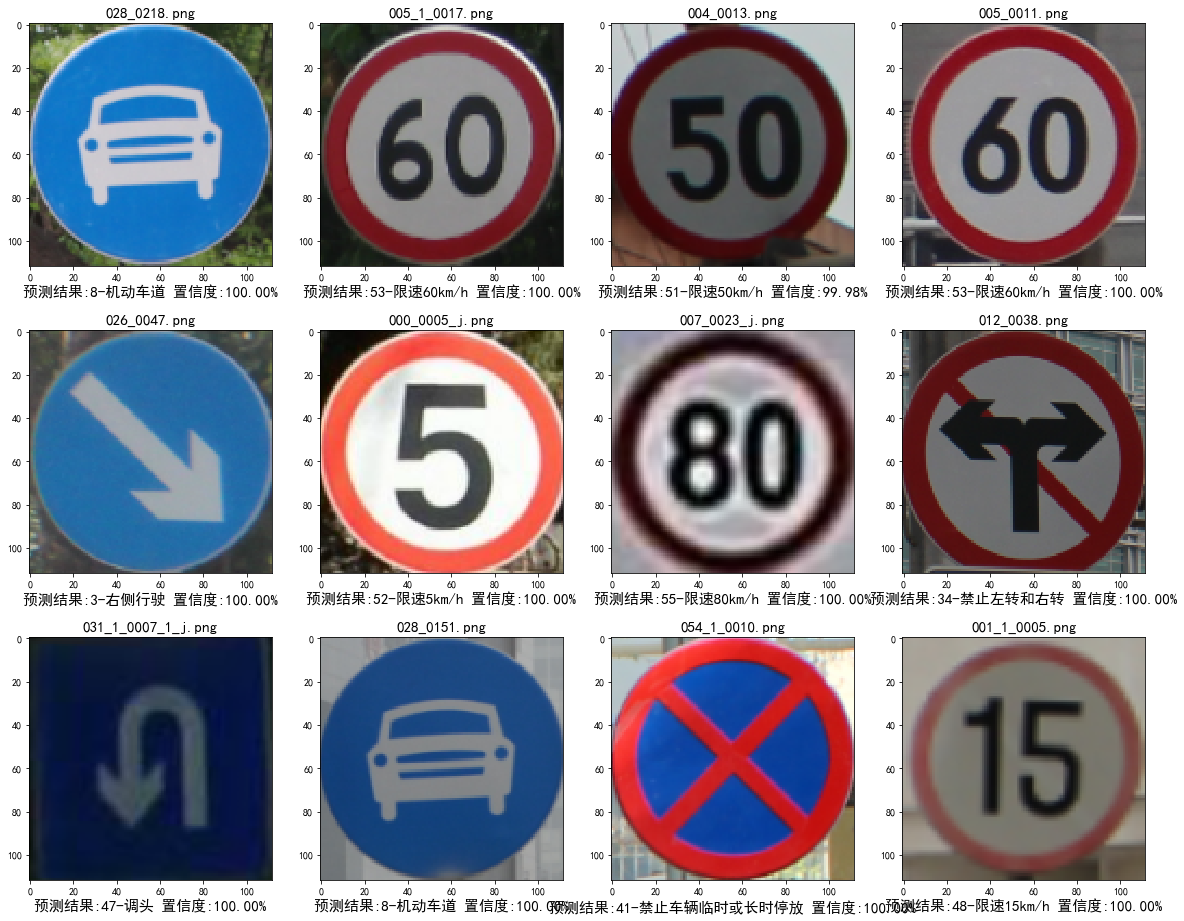

In [13]:
vali_path = './dataset/CTSRD_resized/'
vali_filenames = os.listdir(vali_path)
randNums = random.sample(range(0, len(vali_filenames)), 12)
plt.figure(figsize=(20,16))
for i in range(0,12):
    filename = vali_filenames[randNums[i]]
    image_path = vali_path + '/' + filename
    img = image.load_img(image_path, target_size=(112, 112))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) /255
    pred = model.predict(x)
    index = np.argmax(pred)
    result_name = getname(index)
        
    plt.subplot(3,4,i+1)
    plt.imshow(x[0])
    plt.title(filename, fontsize=15)
    plt.xlabel("预测结果:%d-%s 置信度:%.2f%%"%(index, result_name, pred[0, index]*100), fontsize=15)